## Preprocessing the data

Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:

In [115]:
import pandas as pd
import holidays
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from darts import TimeSeries
from darts.metrics import mape, rmse, mae


# Read a pandas DataFrame 2023
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")
load2024 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2024.csv", delimiter=",")
load_df = pd.concat([load2023, load2024], ignore_index=True)

# Read temperature data
weather_data = pd.read_csv("Temperature Data/smhi-opendata_1_98230_202301_202412.csv", delimiter=";", skiprows=9)

# Process load data
load_df['Time (UTC)'] = load_df['Time (UTC)'].str.split(' - ').str[0]
#load_df = load_df.drop('Day-ahead Total Load Forecast [MW] - BZN|SE3', axis=1)   
load_df = load_df.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load'})
load_df['datetime'] = pd.to_datetime(load_df['completetime'], format='%d.%m.%Y %H:%M')
load_df = load_df.drop(['completetime'], axis=1)

# Create datetime in weather_data - adjust column names as needed
date_col = 'Datum'  # Adjust this to your actual date column name
time_col = 'Tid (UTC)'  # Adjust this to your actual time column name

# Create datetime column in weather_data by combining date and time
weather_data['datetime'] = pd.to_datetime(
    weather_data[date_col].astype(str) + ' ' + weather_data[time_col].astype(str)
)

# Create a temporary dataframe with just datetime and temperature
temp_df = weather_data[['datetime', 'Lufttemperatur']].copy()
temp_df.rename(columns={'Lufttemperatur': 'Temperature'}, inplace=True)

# Remove any duplicates in temperature data
if temp_df['datetime'].duplicated().any():
    print(f"Found {temp_df['datetime'].duplicated().sum()} duplicate timestamps in temperature data")
    temp_df = temp_df.drop_duplicates(subset=['datetime'])

# Merge the dataframes based on datetime
print(f"Load data shape before merge: {load_df.shape}")
load_df = load_df.merge(temp_df, on='datetime', how='left')
print(f"Load data shape after merge: {load_df.shape}")

# Check for missing temperature values and identify where they are
missing_temp = load_df['Temperature'].isna().sum()
print(f"\nMissing temperature values after merge: {missing_temp}")

if missing_temp > 0:
    # Find rows with missing temperature values
    missing_rows = load_df[load_df['Temperature'].isna()]
    
    # Display information about the missing data
    print("\nRows with missing temperature values:")
    print(f"Total missing values: {len(missing_rows)}")
    
    # Show the first few rows with missing values
    print("\nFirst 10 rows with missing temperature values:")
    print(missing_rows[['datetime', 'Load']].head(10))
    
    # Show the distribution of missing values by month and hour
    print("\nMissing values by month:")
    print(missing_rows['datetime'].dt.month.value_counts().sort_index())
    
    print("\nMissing values by hour of day:")
    print(missing_rows['datetime'].dt.hour.value_counts().sort_index())
    
    # Check if missing values are consecutive
    missing_rows_sorted = missing_rows.sort_values('datetime')
    time_diff = missing_rows_sorted['datetime'].diff()
    
    print("\nTime differences between consecutive missing values (first 10):")
    print(time_diff.head(10))
    
    # Identify gaps in temperature data
    common_diff = time_diff.mode()[0]
    print(f"Most common time difference between missing values: {common_diff}")
    
    # Set datetime as index for time-based interpolation
    load_df_temp = load_df.set_index('datetime')
    
    # Perform interpolation
    load_df_temp['Temperature'] = load_df_temp['Temperature'].interpolate(method='time')
    
    # Handle any remaining missing values
    load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')
    
    # Reset index
    load_df = load_df_temp.reset_index()
    
    print(f"\nRemaining missing values after interpolation: {load_df['Temperature'].isna().sum()}")

# Adding day type
load_df['Month'] = load_df['datetime'].dt.month
load_df['Day_of_week'] = load_df['datetime'].dt.dayofweek
load_df['Hour_of_day'] = load_df['datetime'].dt.hour

# change column name
load_df['entso-e_forecast']=load_df['Day-ahead Total Load Forecast [MW] - BZN|SE3']
# Adding Holidays (excluding Sundays)
Sweden_holidays = holidays.CountryHoliday('SE')
load_df['Holidays'] = [int((date in Sweden_holidays) and date.weekday() != 6) for date in load_df.datetime]
#load_df['Holidays'] = [int(date in Sweden_holidays) for date in load_df.datetime]
# Reorder columns
load_df = load_df[['datetime', 'entso-e_forecast','Load', 'Temperature', 'Month','Day_of_week', 'Hour_of_day', 'Holidays']]

# Display a sample of the final dataframe
print("\nFinal dataframe sample:")
print(load_df.head())

# Convert the panda data frame into DART dataseries
Load = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Load"]
)

Temp = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Temperature"]
)

Holidays = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Holidays"]
)

load_df



Load data shape before merge: (17544, 3)
Load data shape after merge: (17544, 4)

Missing temperature values after merge: 9

Rows with missing temperature values:
Total missing values: 9

First 10 rows with missing temperature values:
                 datetime   Load
6800  2023-10-11 08:00:00   9888
6801  2023-10-11 09:00:00   9850
6802  2023-10-11 10:00:00   9679
6803  2023-10-11 11:00:00   9544
6805  2023-10-11 13:00:00   9245
6943  2023-10-17 07:00:00  10537
6944  2023-10-17 08:00:00  10341
14983 2024-09-16 07:00:00   9398
14984 2024-09-16 08:00:00   9359

Missing values by month:
datetime
9     2
10    7
Name: count, dtype: int64

Missing values by hour of day:
datetime
7     2
8     3
9     1
10    1
11    1
13    1
Name: count, dtype: int64

Time differences between consecutive missing values (first 10):
6800                  NaT
6801      0 days 01:00:00
6802      0 days 01:00:00
6803      0 days 01:00:00
6805      0 days 02:00:00
6943      5 days 18:00:00
6944      0 days 01:00

C:\Users\jakfa\AppData\Local\Temp\ipykernel_12128\3570787758.py:90: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')


,datetime,entso-e_forecast,Load,Temperature,Month,Day_of_week,Hour_of_day,Holidays
0,2023-01-01 00:00:00,8897,8943,3.6,1,6,0,0
1,2023-01-01 01:00:00,8836,8929,3.0,1,6,1,0
2,2023-01-01 02:00:00,8779,8887,2.6,1,6,2,0
3,2023-01-01 03:00:00,8806,8859,2.4,1,6,3,0
4,2023-01-01 04:00:00,8958,8880,2.0,1,6,4,0
...,...,...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,10929,11092,-2.1,12,1,19,1
17540,2024-12-31 20:00:00,10568,10798,-1.8,12,1,20,1
17541,2024-12-31 21:00:00,10272,10531,-3.0,12,1,21,1
17542,2024-12-31 22:00:00,9981,10165,-2.7,12,1,22,1


Decision Tree

In [103]:
# Check the dataframe information
load_df.info()
load_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     17544 non-null  datetime64[ns]
 1   Load         17544 non-null  int64         
 2   Temperature  17544 non-null  float64       
 3   Month        17544 non-null  int32         
 4   Day_of_week  17544 non-null  int32         
 5   Hour_of_day  17544 non-null  int32         
 6   Holidays     17544 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(2)
memory usage: 754.0 KB


datetime       0
Load           0
Temperature    0
Month          0
Day_of_week    0
Hour_of_day    0
Holidays       0
dtype: int64

In [104]:
# To see summary statistics
load_df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,17544,2024-01-01 11:30:00,2023-01-01 00:00:00,2023-07-02 17:45:00,2024-01-01 11:30:00,2024-07-02 05:15:00,2024-12-31 23:00:00,NaN
Load,17544.0,9504.454742,5198.0,7809.0,9205.5,11059.25,16747.0,2111.719109
Temperature,17544.0,8.343243,-14.2,1.6,7.5,15.6,29.6,8.384944
Month,17544.0,6.519836,1.0,4.0,7.0,10.0,12.0,3.449649
Day_of_week,17544.0,2.997264,0.0,1.0,3.0,5.0,6.0,2.003472
Hour_of_day,17544.0,11.5,0.0,5.75,11.5,17.25,23.0,6.922384
Holidays,17544.0,0.0342,0.0,0.0,0.0,0.0,1.0,0.181747


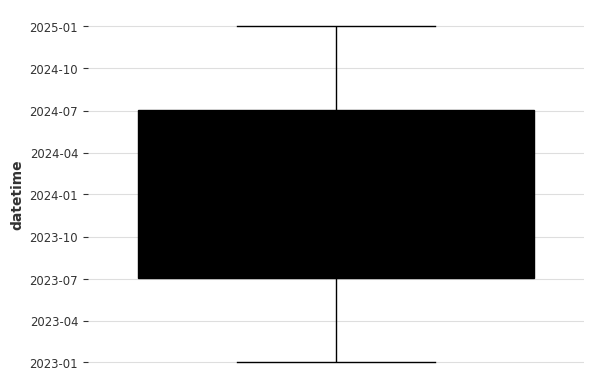

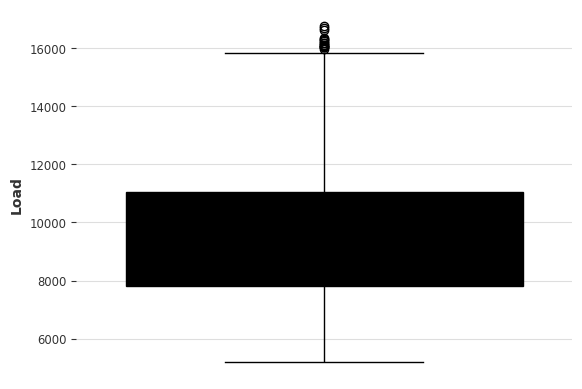

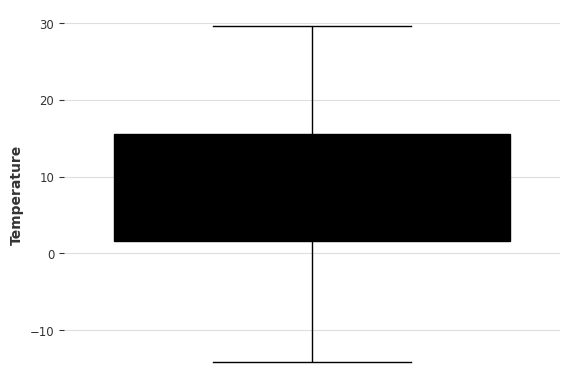

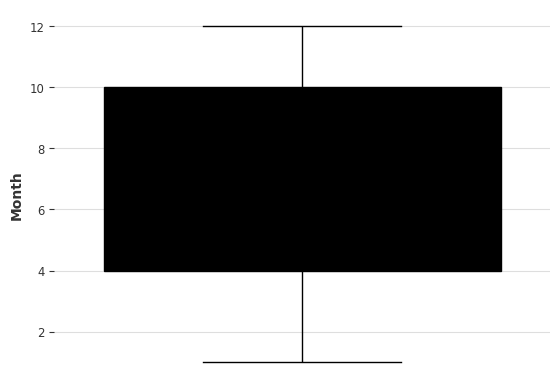

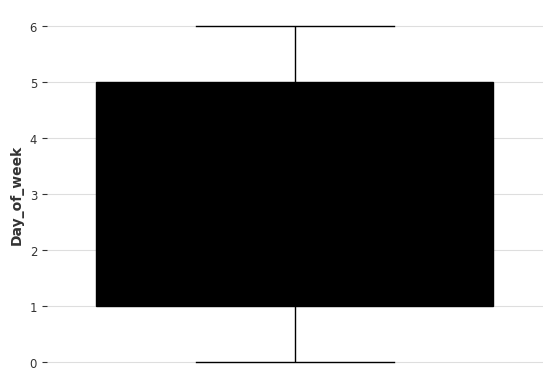

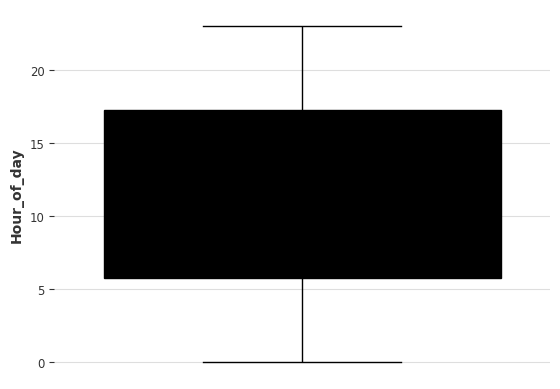

In [105]:
# To find outliers
cols = load_df.columns[0:-1]
for i in cols:
    sns.boxplot(y=load_df[i])
    plt.show()

Set Training Data

In [106]:
load_train, load_test = Load.split_before(pd.to_datetime('2024-10-31'))

Test Using Naive Model

In [11]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=168)
naive_model.fit(load_train)
prediction = naive_model.predict(len(load_test))

Plot Naive

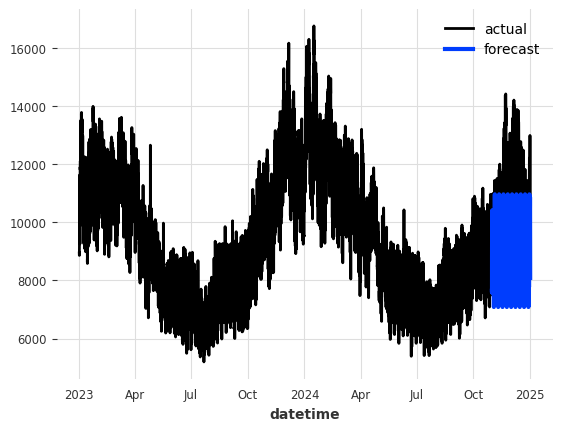

In [12]:
Load.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

Zoom the Plot

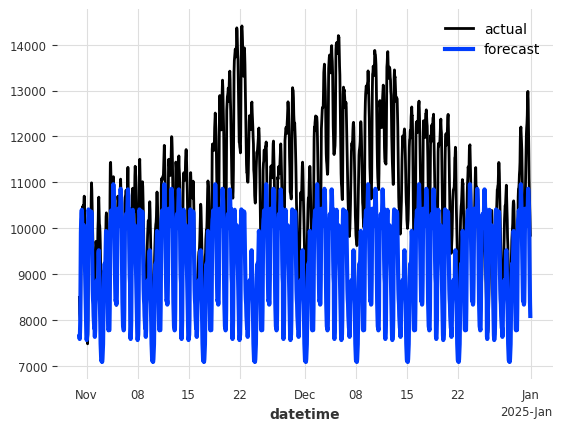

In [13]:
load_test.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()


Well, we have our first model (albeit a rather poor one, it seems). Before proceeding further, let's make our model creation and selection process a bit more formal. To do so, recall that machine learning models are not evaluated only once, rather we use cross-validation. Similarly for time series, you do not want to make one prediction for 2.5 months, rather you want to periodically update your predictions, perhaps every day or even every hour. 

Let's now create a function to evaluate different models using backtesting (this is widely used in practice with time series methods and can be seen as a way to do cross-validation for time series). It is therefore necessary to get a more robust estimate of a model's forecasting performance, and is definitely preferable to simply fitting a single model to the entire dataset. The downside is obviously that it is more computationally intensive.

In [46]:
def eval_model(model, past_covariates=None, future_covariates=None, to_retrain=True):
    
    backtest = model.historical_forecasts(series=Load, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2024-10-30'), 
                                          retrain=to_retrain,
                                          verbose=False, 
                                          forecast_horizon=24)
    
    Load[-len(backtest)-336:].plot()
    backtest.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(Load, backtest)))
    plt.show()

    error = Load[-len(backtest):].to_series() - backtest.to_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()

Eval the model using backtest (Naive seasonal K=168)

Backtest MAPE = 9.24981994412691


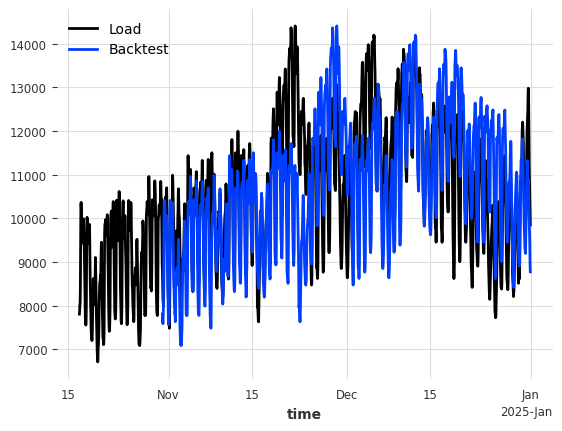

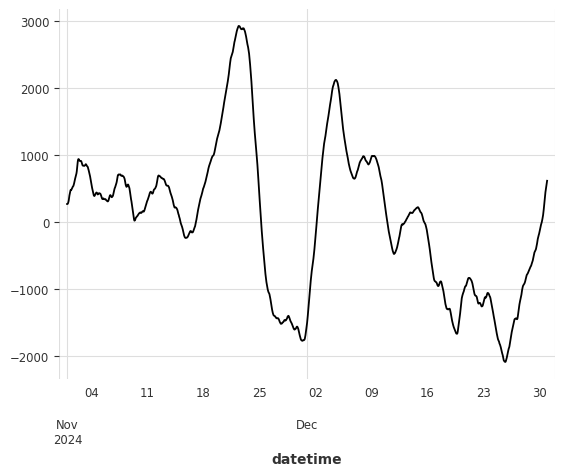

In [15]:
naive_model = NaiveSeasonal(K=168)
naive_model.fit(load_train)
eval_model(naive_model)

Eval the model using backtest (Naive seasonal K=24)

Backtest MAPE = 5.955488016743289


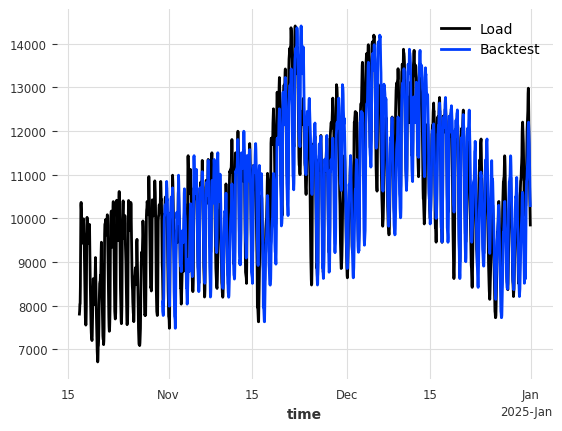

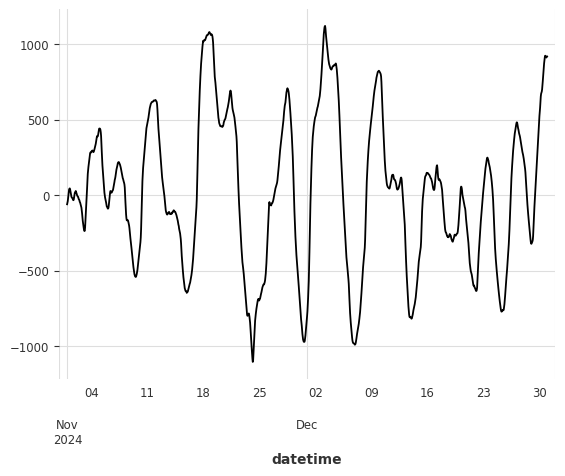

In [16]:
naive_model = NaiveSeasonal(K=24)
naive_model.fit(load_train)
eval_model(naive_model)

Using Theta Model

c:\Users\jakfa\Documents\Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jakfa\Documents\Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jakfa\Documents\Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jakfa\Documents\Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jakfa\Documents\Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jakfa\Documents\Project\.venv\Lib\site-packages\sta

Backtest MAPE = 4.812365375509025


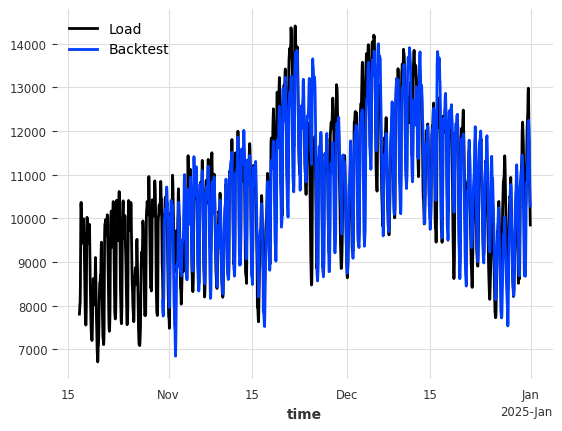

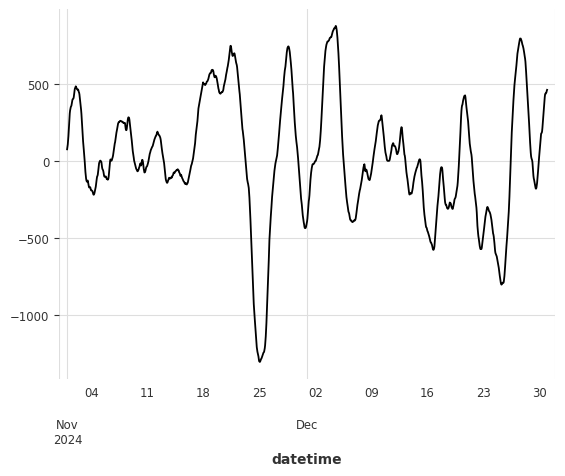

In [17]:
from darts.models import Theta

theta_model = Theta(seasonality_period=168)
theta_model.fit(load_train)
eval_model(theta_model)

Regression (Lags = 168)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Backtest MAPE = 5.587470224611538


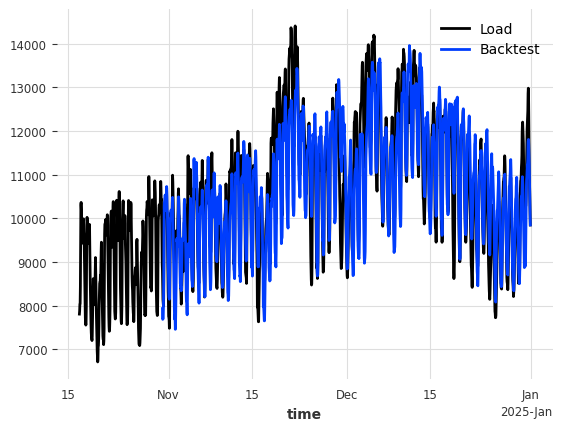

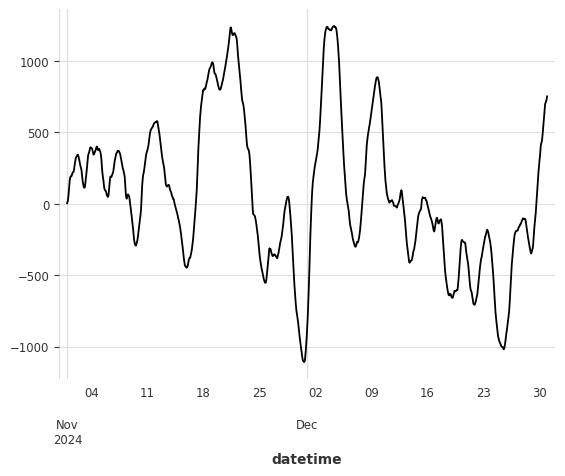

In [19]:
from darts.models import RegressionModel

regr_model_lags = RegressionModel(lags=list(range(-168,0)))
regr_model_lags.fit(load_train)
eval_model(regr_model_lags, to_retrain=False)

Regression (Lags=672)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Backtest MAPE = 5.227104751358231


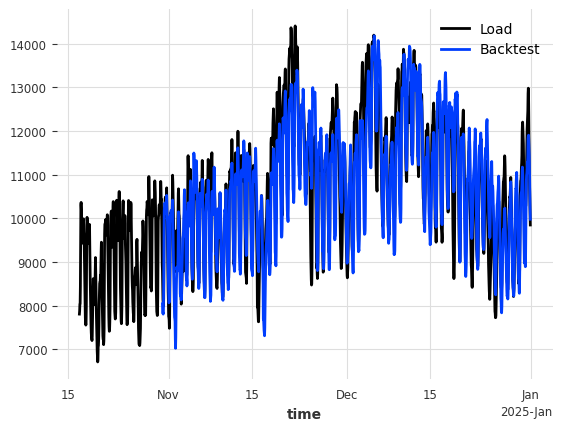

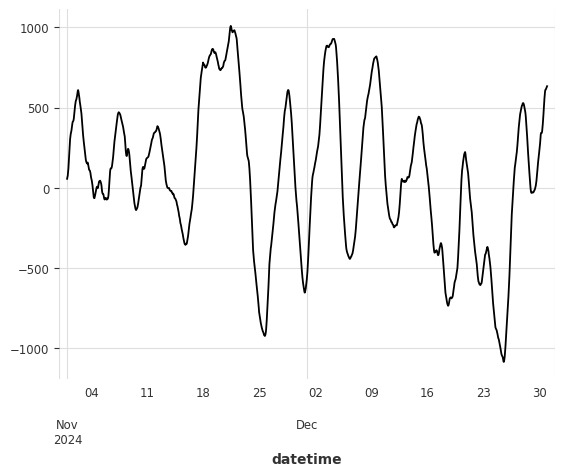

In [20]:
regr_model_cov = RegressionModel(lags=list(range(-672,0)))
regr_model_cov.fit(load_train)
eval_model(regr_model_cov, to_retrain=False)

Regression with covariates (Day type and Holidays)

Backtest MAPE = 5.066945319385356


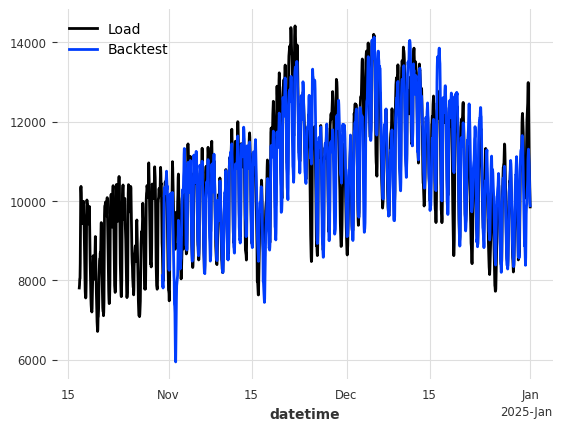

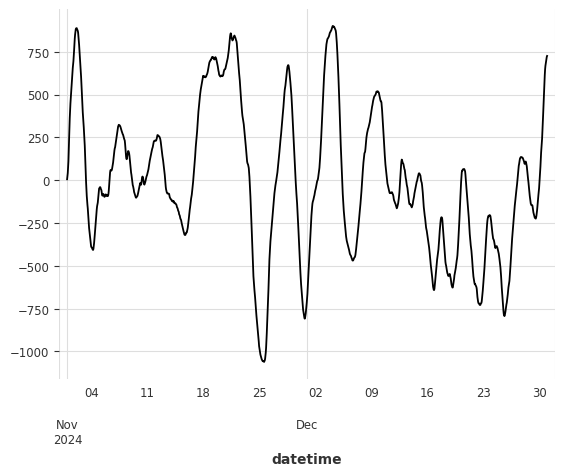

In [47]:
future = TimeSeries.from_dataframe(load_df, time_col="datetime",value_cols=['Month','Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov = RegressionModel(lags=list(range(-672,0)),
                                 lags_future_covariates=list(range(24)),
                                 output_chunk_length=24
                                 )
regr_model_cov.fit(load_train, 
                   future_covariates=future)

eval_model(regr_model_cov, to_retrain=False)

Regression with covariates (Day type and Holidays) + Temprature

Backtest MAPE = 3.1952856570399946


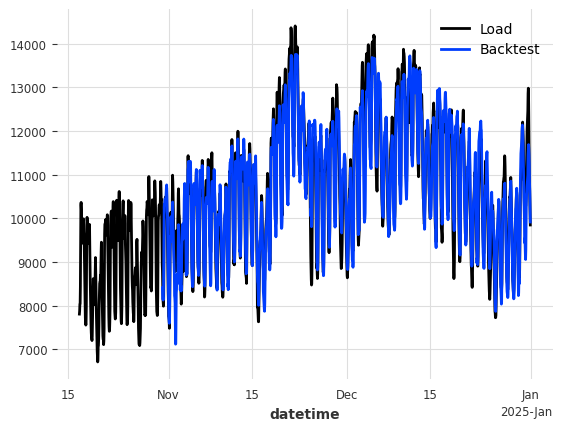

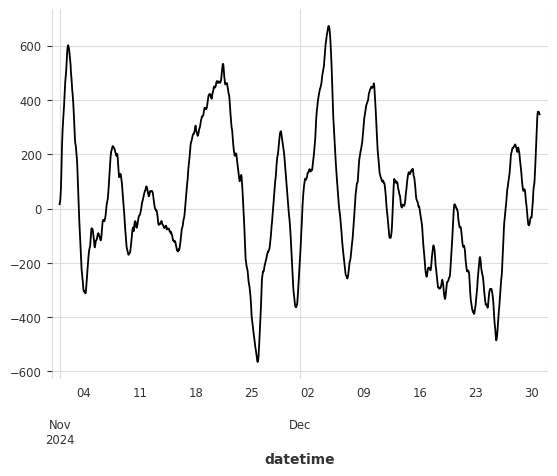

In [48]:
future = TimeSeries.from_dataframe(load_df, time_col="datetime",value_cols=['Temperature','Month','Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov = RegressionModel(lags=list(range(-672,0)),
                                 lags_future_covariates=list(range(24)),
                                 output_chunk_length=24
                                 )
regr_model_cov.fit(load_train, 
                   future_covariates=future)

eval_model(regr_model_cov, to_retrain=False)

In [25]:
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
load_train_transformed = transformer.fit_transform(load_train)
load_test_transformed = transformer.transform(load_test)
Load_transformed = transformer.transform(Load)


Using RNN LSTM (Without Covariates)

In [ ]:


rnn_model = RNNModel(model= 'LSTM',
                    input_chunk_length=72, 
                    training_length=96, 
                    n_rnn_layers=2)

rnn_model.fit(load_train_transformed, 
             future_covariates=None,
             epochs=100, 
             verbose=True)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 13.2 K | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 522/522 [01:57<00:00,  4.46it/s, train_loss=0.00014] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 522/522 [01:57<00:00,  4.46it/s, train_loss=0.00014]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=3, dropout=0.0, training_length=96, input_chunk_length=72)

In [ ]:
def eval_model_transform(model, past_covariates=None, future_covariates=None, to_retrain=True):
    
    backtest = model.historical_forecasts(series=Load_transformed, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2024-10-30'), 
                                          retrain=to_retrain,
                                          verbose=False, 
                                          forecast_horizon=24)
    
    # Inverse-transform predictions to original scale
    backtest_scaled = transformer.inverse_transform(backtest)

    Load[-len(backtest)-336:].plot()
    backtest_scaled.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(Load, backtest_scaled)))
    plt.show()

    error = Load[-len(backtest_scaled):].to_series() - backtest_scaled.to_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()


Using RNN (LSTM with covariates)

In [ ]:
rnn_model_cov = RNNModel(model= 'LSTM',
                    input_chunk_length=72, 
                    training_length=96, 
                    n_rnn_layers=2)

rnn_model_cov.fit(load_train_transformed, 
             future_covariates=future,
             epochs=100, 
             verbose=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.3 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.3 K     Trainable params
0         Non-trainable params
8.3 K     Total params
0.033     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 522/522 [01:30<00:00,  5.75it/s, train_loss=0.000105]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 522/522 [01:30<00:00,  5.74it/s, train_loss=0.000105]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=2, dropout=0.0, training_length=96, input_chunk_length=72)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 4.977836349087973


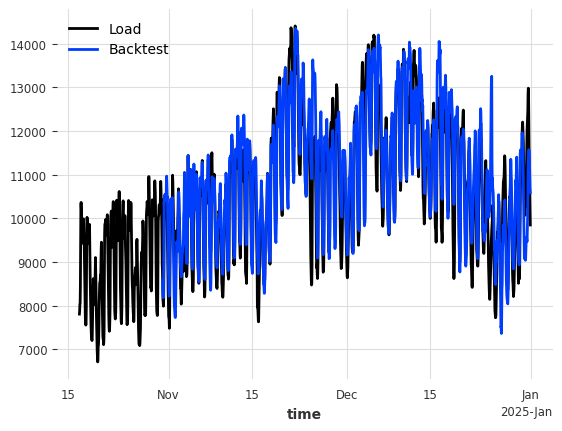

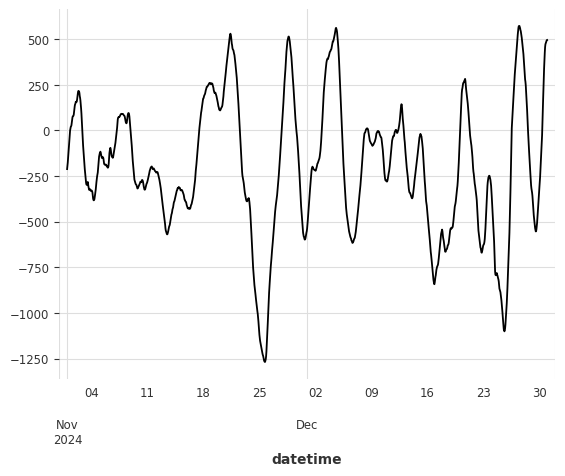

In [41]:
eval_model_transform(rnn_model_cov,to_retrain=False)    

In [107]:
import pytz

# Define Sweden timezone
sweden_tz = pytz.timezone('Europe/Stockholm')

def is_dst_sweden(naive_dt):
    try:
        # First, assume the naive datetime is in UTC
        utc_dt = pd.Timestamp(naive_dt).tz_localize('UTC')
        # Then convert UTC time to Sweden time
        sweden_time = utc_dt.astimezone(sweden_tz)
        # Return 1 if DST is active, 0 if not
        return int(sweden_time.dst() != pd.Timedelta(0))
    except Exception as e:
        print(f"Error processing {naive_dt}: {e}")
        return None

# Apply the function to get DST status (1 or 0)
load_df['daylight_saving'] = load_df['datetime'].apply(is_dst_sweden)


In [63]:
print(load_df.iloc[12350])
load_df

datetime           2024-05-29 14:00:00
Load                              8708
Temperature                       21.6
Month                                5
Day_of_week                          2
Hour_of_day                         14
Holidays                             0
daylight_saving                      1
Name: 12350, dtype: object


,datetime,Load,Temperature,Month,Day_of_week,Hour_of_day,Holidays,daylight_saving
0,2023-01-01 00:00:00,8943,3.6,1,6,0,0,0
1,2023-01-01 01:00:00,8929,3.0,1,6,1,0,0
2,2023-01-01 02:00:00,8887,2.6,1,6,2,0,0
3,2023-01-01 03:00:00,8859,2.4,1,6,3,0,0
4,2023-01-01 04:00:00,8880,2.0,1,6,4,0,0
...,...,...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,11092,-2.1,12,1,19,1,0
17540,2024-12-31 20:00:00,10798,-1.8,12,1,20,1,0
17541,2024-12-31 21:00:00,10531,-3.0,12,1,21,1,0
17542,2024-12-31 22:00:00,10165,-2.7,12,1,22,1,0


LSTM with adding daylight saving covariates with month

In [108]:
future_with_dst = TimeSeries.from_dataframe(load_df, time_col="datetime",value_cols=['Temperature','Month','Day_of_week', 'Hour_of_day', 'Holidays','daylight_saving'])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 499/499 [01:12<00:00,  6.89it/s, train_loss=8.37e-5] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 499/499 [01:12<00:00,  6.89it/s, train_loss=8.37e-5]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 3.529621659712245


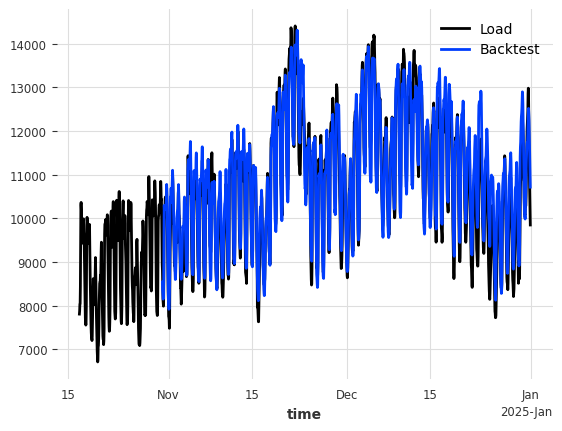

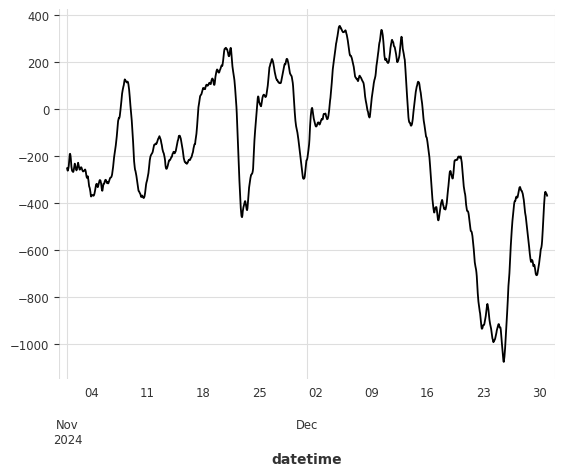

In [67]:
rnn_model_cov_dst = RNNModel(model= 'LSTM',
                    input_chunk_length=72, 
                    training_length=96, 
                    n_rnn_layers=2)

rnn_model_cov_dst.fit(load_train_transformed, 
             future_covariates=future_with_dst,
             epochs=100, 
             verbose=True)

eval_model_transform(rnn_model_cov_dst,to_retrain=False)    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.88it/s]


<Axes: xlabel='datetime'>

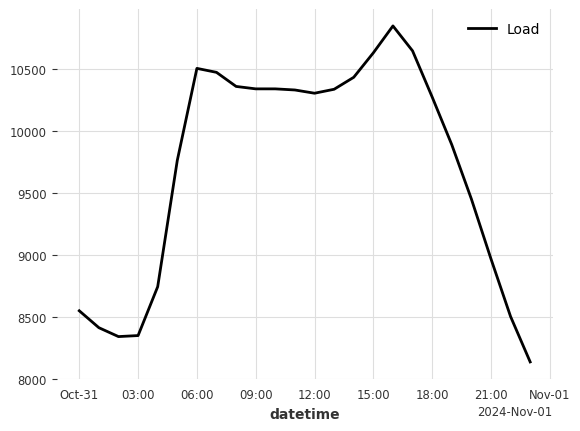

In [90]:
pred=transformer.inverse_transform(rnn_model_cov_dst.predict(24))


pred.plot()


With month

In [109]:
future_with_month = TimeSeries.from_dataframe(load_df, time_col="datetime",value_cols=['Temperature','Month','Day_of_week', 'Hour_of_day', 'Holidays','daylight_saving'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 499/499 [00:32<00:00, 15.45it/s, train_loss=8.93e-5] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 499/499 [00:32<00:00, 15.45it/s, train_loss=8.93e-5]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 3.37721759910304


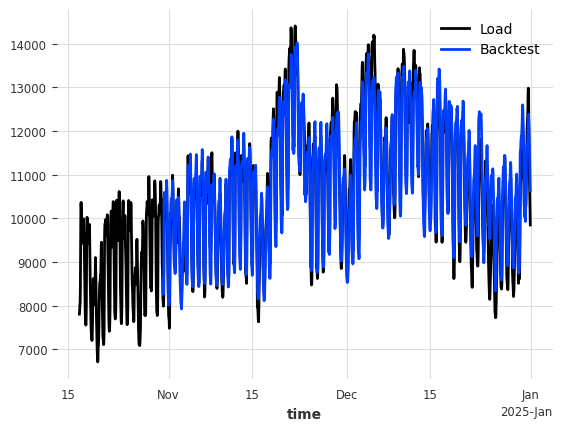

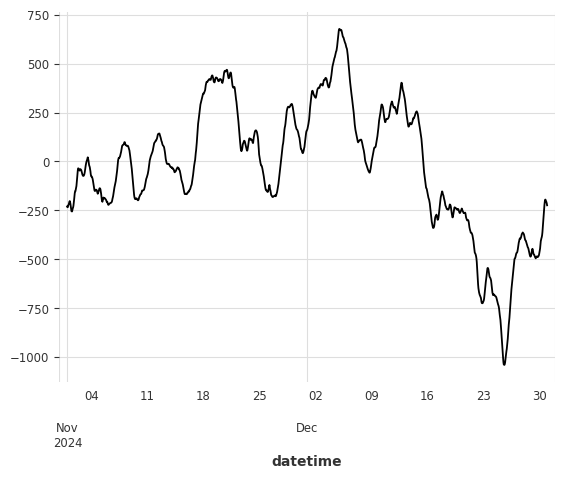

In [110]:
rnn_model_cov_dst = RNNModel(model= 'LSTM',
                    input_chunk_length=72, 
                    training_length=96, 
                    n_rnn_layers=2)

rnn_model_cov_dst.fit(load_train_transformed, 
             future_covariates=future_with_month,
             epochs=100, 
             verbose=True)

eval_model_transform(rnn_model_cov_dst,to_retrain=False)    

entso-e MAPE

Backtest MAPE = 2.540147007186436
Backtest MAE = 238.06007751937983
Backtest MSE = 96190.6103511172
Backtest RMSE = 310.1461112945271


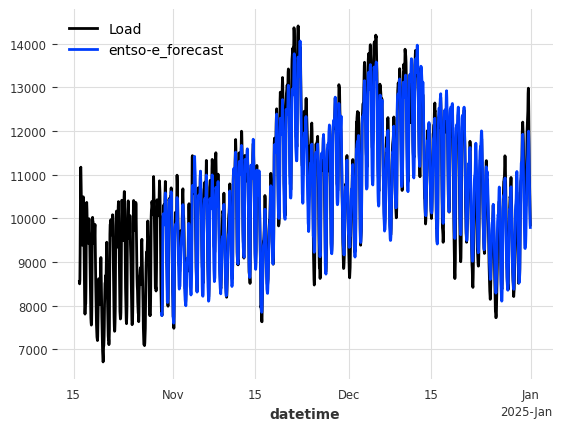

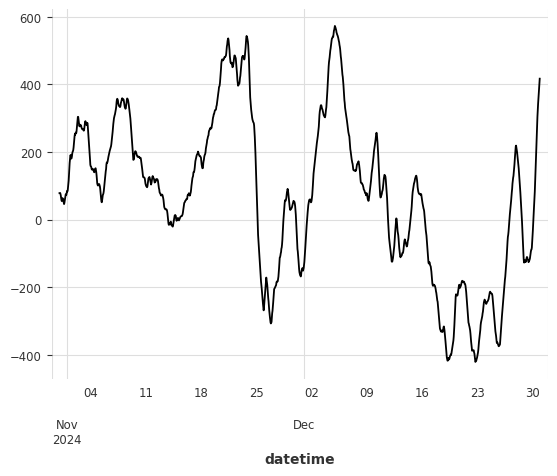

In [128]:
from darts.metrics import mape, rmse, mae, mse
forecast = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["entso-e_forecast"]
)

start_date = pd.Timestamp("2024-10-30")
filtered_df = load_df[load_df["datetime"] >= start_date]


Load[-len(filtered_df)-336:].plot()
forecast[-len(filtered_df):].plot()
print('Backtest MAPE = {}'.format(mape(Load,forecast)))
print('Backtest MAE = {}'.format(mae(Load,forecast)))
print('Backtest MSE = {}'.format(mse(Load,forecast)))
print('Backtest RMSE = {}'.format(rmse(Load,forecast)))

plt.show()

error = Load[-len(filtered_df):].to_series() - forecast[-len(filtered_df):].to_series()
error.rolling(49, center=True).mean().plot()
plt.show()

In [129]:
Sweden_holidays

{datetime.date(2023, 1, 1): 'Nyårsdagen; Söndag', datetime.date(2023, 1, 6): 'Trettondedag jul', datetime.date(2023, 4, 7): 'Långfredagen', datetime.date(2023, 4, 9): 'Påskdagen; Söndag', datetime.date(2023, 4, 10): 'Annandag påsk', datetime.date(2023, 5, 1): 'Första maj', datetime.date(2023, 5, 18): 'Kristi himmelsfärdsdag', datetime.date(2023, 6, 6): 'Sveriges nationaldag', datetime.date(2023, 5, 28): 'Pingstdagen; Söndag', datetime.date(2023, 6, 23): 'Midsommarafton', datetime.date(2023, 6, 24): 'Midsommardagen', datetime.date(2023, 11, 4): 'Alla helgons dag', datetime.date(2023, 12, 24): 'Julafton; Söndag', datetime.date(2023, 12, 25): 'Juldagen', datetime.date(2023, 12, 26): 'Annandag jul', datetime.date(2023, 12, 31): 'Nyårsafton; Söndag', datetime.date(2023, 1, 8): 'Söndag', datetime.date(2023, 1, 15): 'Söndag', datetime.date(2023, 1, 22): 'Söndag', datetime.date(2023, 1, 29): 'Söndag', datetime.date(2023, 2, 5): 'Söndag', datetime.date(2023, 2, 12): 'Söndag', datetime.date(2023